                   dist       n      mean       std       q05    median  \
0           Normal(0,1)  100000  0.000967  1.000906 -1.643489  0.002650   
1  LogNormal(sigma=0.6)  100000  1.197080  0.782987  0.373841  1.000301   
2       Student-t(df=5)  100000  0.002857  1.289610 -2.005022  0.003621   

        q95  
0  1.650524  
1  2.680115  
2  2.019226  


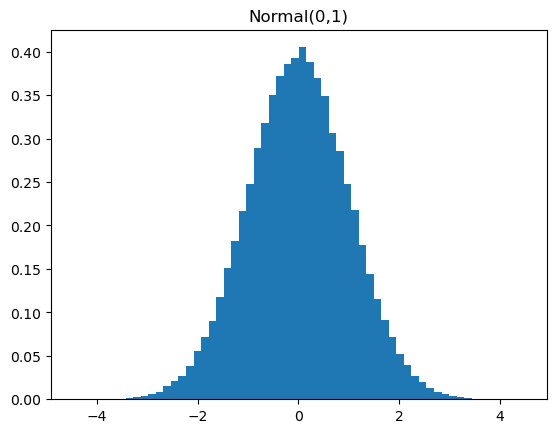

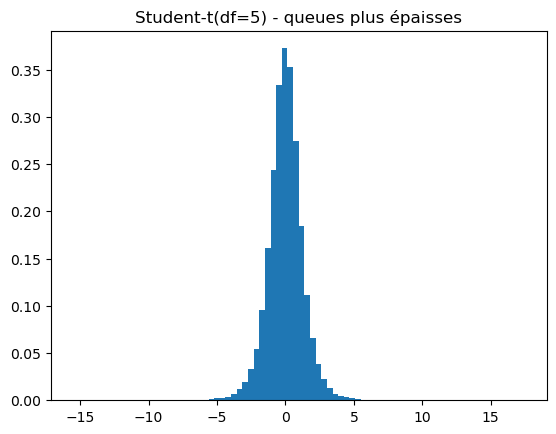

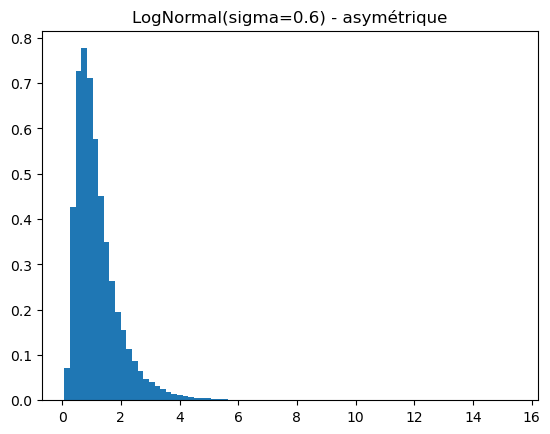

P(X>2) estimée = 0.02126
Moyenne estimée = -0.0036245490397031573
Ecart-type estimé = 0.9963279653247415


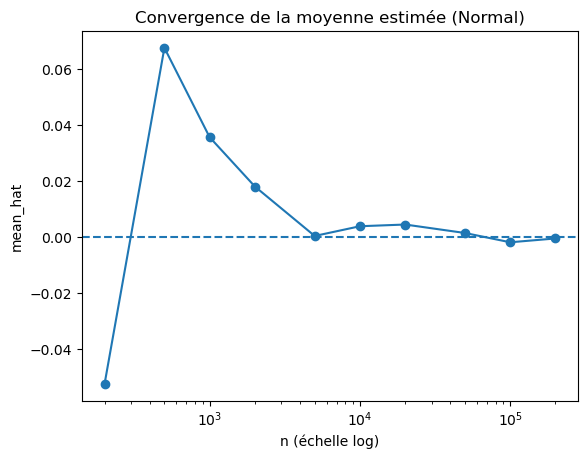

  variable       n      mean       std       q05   median       q95
0        Y  100000  4.012802  0.552966  3.149523  3.98675  4.965197


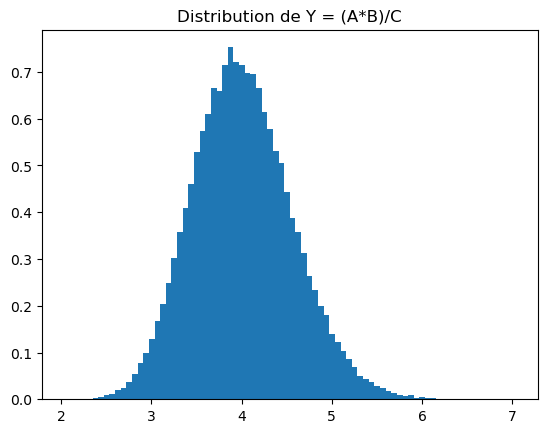

  input  corr_with_Y
0     A     0.359350
1     B     0.727163
2     C    -0.576305
✅ Excel généré : report_montecarlo.xlsx


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pour rendre tes résultats reproductibles
np.random.seed(42)

# -----------------------
# 1) Distributions
# -----------------------
N = 100_000

normal = np.random.normal(0, 1, N)
lognormal = np.random.lognormal(mean=0, sigma=0.6, size=N)
student = np.random.standard_t(df=5, size=N)

def summarize(x):
    return {
        "n": len(x),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)),
        "q05": float(np.quantile(x, 0.05)),
        "median": float(np.quantile(x, 0.50)),
        "q95": float(np.quantile(x, 0.95)),
    }

dist_stats = pd.DataFrame([
    {"dist": "Normal(0,1)", **summarize(normal)},
    {"dist": "LogNormal(sigma=0.6)", **summarize(lognormal)},
    {"dist": "Student-t(df=5)", **summarize(student)},
])

print(dist_stats)

# Visu simple
plt.figure()
plt.hist(normal, bins=60, density=True)
plt.title("Normal(0,1)")
plt.show()

plt.figure()
plt.hist(student, bins=80, density=True)
plt.title("Student-t(df=5) - queues plus épaisses")
plt.show()

plt.figure()
plt.hist(lognormal, bins=80, density=True)
plt.title("LogNormal(sigma=0.6) - asymétrique")
plt.show()


# -----------------------
# 2) Estimation Monte Carlo (moyenne & proba)
# -----------------------
x = np.random.normal(0, 1, 50_000)
p_hat = np.mean(x > 2.0)        # estimation de P(X>2)
mean_hat = np.mean(x)           # estimation E[X]
std_hat = np.std(x, ddof=1)     # estimation std

print("P(X>2) estimée =", p_hat)
print("Moyenne estimée =", mean_hat)
print("Ecart-type estimé =", std_hat)


# -----------------------
# 3) Convergence
# -----------------------
x = np.random.normal(0, 1, 200_000)

steps = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
means = []

for n in steps:
    means.append(np.mean(x[:n]))

conv_df = pd.DataFrame({"n": steps, "mean_hat": means})

plt.figure()
plt.plot(conv_df["n"], conv_df["mean_hat"], marker="o")
plt.xscale("log")
plt.title("Convergence de la moyenne estimée (Normal)")
plt.xlabel("n (échelle log)")
plt.ylabel("mean_hat")
plt.axhline(0, linestyle="--")
plt.show()


# -----------------------
# 4) Propagation d'incertitudes
# -----------------------
N = 100_000
A = np.random.normal(100, 5, N)
B = np.random.normal(2.0, 0.2, N)
C = np.random.lognormal(mean=np.log(50), sigma=0.08, size=N)  # toujours positif

Y = (A * B) / C

y_stats = pd.DataFrame([{"variable": "Y", **summarize(Y)}])
print(y_stats)

plt.figure()
plt.hist(Y, bins=80, density=True)
plt.title("Distribution de Y = (A*B)/C")
plt.show()

# Sensibilité très simple : corrélation avec Y
sens_df = pd.DataFrame({
    "input": ["A", "B", "C"],
    "corr_with_Y": [np.corrcoef(A, Y)[0,1], np.corrcoef(B, Y)[0,1], np.corrcoef(C, Y)[0,1]]
})
print(sens_df)


# -----------------------
# 5) Export Excel (reporting)
# -----------------------
with pd.ExcelWriter("report_montecarlo.xlsx") as writer:
    dist_stats.to_excel(writer, sheet_name="Distributions", index=False)
    conv_df.to_excel(writer, sheet_name="Convergence", index=False)
    y_stats.to_excel(writer, sheet_name="Propagation", index=False)
    sens_df.to_excel(writer, sheet_name="Sensitivity", index=False)

print("Excel généré : report_montecarlo.xlsx")
